In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
import os
path='/content/drive/MyDrive/reduced_dataset'

In [3]:
#removing corrupted images
from PIL import Image

def check_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Bad file: {file_path}")
                os.remove(file_path)  # Remove the corrupted file

# Check and clean your dataset directory
dataset_path = '/content/drive/MyDrive/reduced_dataset'
check_images(dataset_path)


Bad file: /content/drive/MyDrive/reduced_dataset/North Indian Cusine/Aloo Puri/Webscrapping.ipynb
Bad file: /content/drive/MyDrive/reduced_dataset/West Indian Cuisine/Modak/7.jpg


In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
train_data=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [13]:
train_gen=train_data.flow_from_directory(
    path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True
)

Found 955 images belonging to 4 classes.


In [14]:
validation_gen=train_data.flow_from_directory(
    path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    shuffle=True
)

Found 237 images belonging to 4 classes.


In [15]:
print(train_gen.class_indices)
print(validation_gen.class_indices)


{'East Indian Cuisine': 0, 'North Indian Cusine': 1, 'South Indian Cuisine': 2, 'West Indian Cuisine': 3}
{'East Indian Cuisine': 0, 'North Indian Cusine': 1, 'South Indian Cuisine': 2, 'West Indian Cuisine': 3}


In [6]:
from tensorflow.keras import layers,models
from tensorflow.keras.applications import VGG16

In [16]:
reference_model=VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
# freezing the layers
for layer in reference_model.layers:
    layer.trainable=False

In [18]:
model=models.Sequential([
    reference_model,
    layers.Flatten(),
    layers.Dense(units=256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=4,activation='softmax')
])

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']

)

In [20]:
print(layer,layer.trainable)

<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7a6d4c93f640> False


In [ ]:
trained_model=model.fit(
    train_gen,
    epochs=20,
    validation_data=validation_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(validation_gen)
)

Epoch 1/20
42/42 [==============================] - 1085s 26s/step - loss: 1.0408 - accuracy: 0.5523 - val_loss: 1.1952 - val_accuracy: 0.5030
Epoch 2/20
42/42 [==============================] - 1158s 28s/step - loss: 1.0168 - accuracy: 0.5636 - val_loss: 1.2410 - val_accuracy: 0.4421
Epoch 3/20
42/42 [==============================] - 1128s 27s/step - loss: 0.9871 - accuracy: 0.5765 - val_loss: 1.2574 - val_accuracy: 0.3933
Epoch 4/20
42/42 [==============================] - 1123s 27s/step - loss: 0.9212 - accuracy: 0.5947 - val_loss: 1.2812 - val_accuracy: 0.4238
Epoch 5/20
42/42 [==============================] - ETA: 0s - loss: 0.9295 - accuracy: 0.6068 

**Saving the Model as .h5 file**

In [ ]:
saved_model=model.save('/content/drive/MyDrive/saved_model/classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/saved_model/classifier.h5')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21138500 (80.64 MB)
Trainable params: 6423812 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [23]:
y_predict=model.predict(validation_gen)

8/8 [==============================] - 22s 2s/step


In [24]:
model.evaluate(validation_gen)

8/8 [==============================] - 6s 624ms/step - loss: 1.0998 - accuracy: 0.5696


[1.0998315811157227, 0.5696202516555786]

In [25]:
from sklearn.metrics import classification_report
y_true=validation_gen.classes
print(classification_report(y_true,y_predict.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.53      0.31      0.39       131
           2       0.00      0.00      0.00        18
           3       0.24      0.62      0.34        58

    accuracy                           0.32       237
   macro avg       0.19      0.23      0.18       237
weighted avg       0.35      0.32      0.30       237



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
#ploting epoch vs val_acc & epoch vs val_loss graph
import matplotlib.pyplot as plt
training_loss=trained_model.history['loss']
test_loss=trained_model.history['val_loss']
training_acc=trained_model.history['accuracy']
test_acc=trained_model.history['val_accuracy']
epochs=range(len(training_loss))

TypeError: 'History' object is not subscriptable

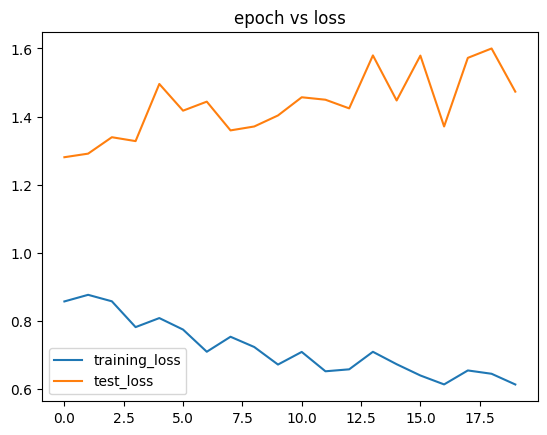

In [ ]:

plt.title('epoch vs loss')
plt.plot(epochs,training_loss,label='training_loss')
plt.plot(epochs,test_loss,label='test_loss')
plt.legend()
plt.show()


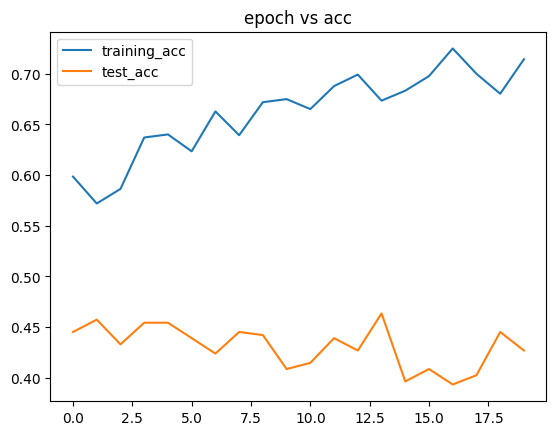

In [ ]:

plt.title('epoch vs acc')
plt.plot(epochs,training_acc,label='training_acc')
plt.plot(epochs,test_acc,label='test_acc')
plt.legend()
plt.show()

Using the Saved model to predict new images as one of the classes

In [28]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
#function to predict images
def predict_image(image_path,saved_model):
  img=image.load_img(image_path,target_size=(224,224))
  img=image.img_to_array(img)
  img=img/255.0

  img=np.expand_dims(img,axis=0)

  prediction=saved_model.predict(img)
  classes=['North_Indian','East_Indian','West_Indian','South_Indian']
  predicted_class=classes[np.argmax(prediction)]

  return predicted_class



In [30]:
saved_model=load_model('/content/drive/MyDrive/saved_model/classifier.h5')
image_path='/content/drive/MyDrive/new.jfif'
predicted_class=predict_image(image_path,saved_model)
print(predicted_class)

1/1 [==============================] - 2s 2s/step
South_Indian
